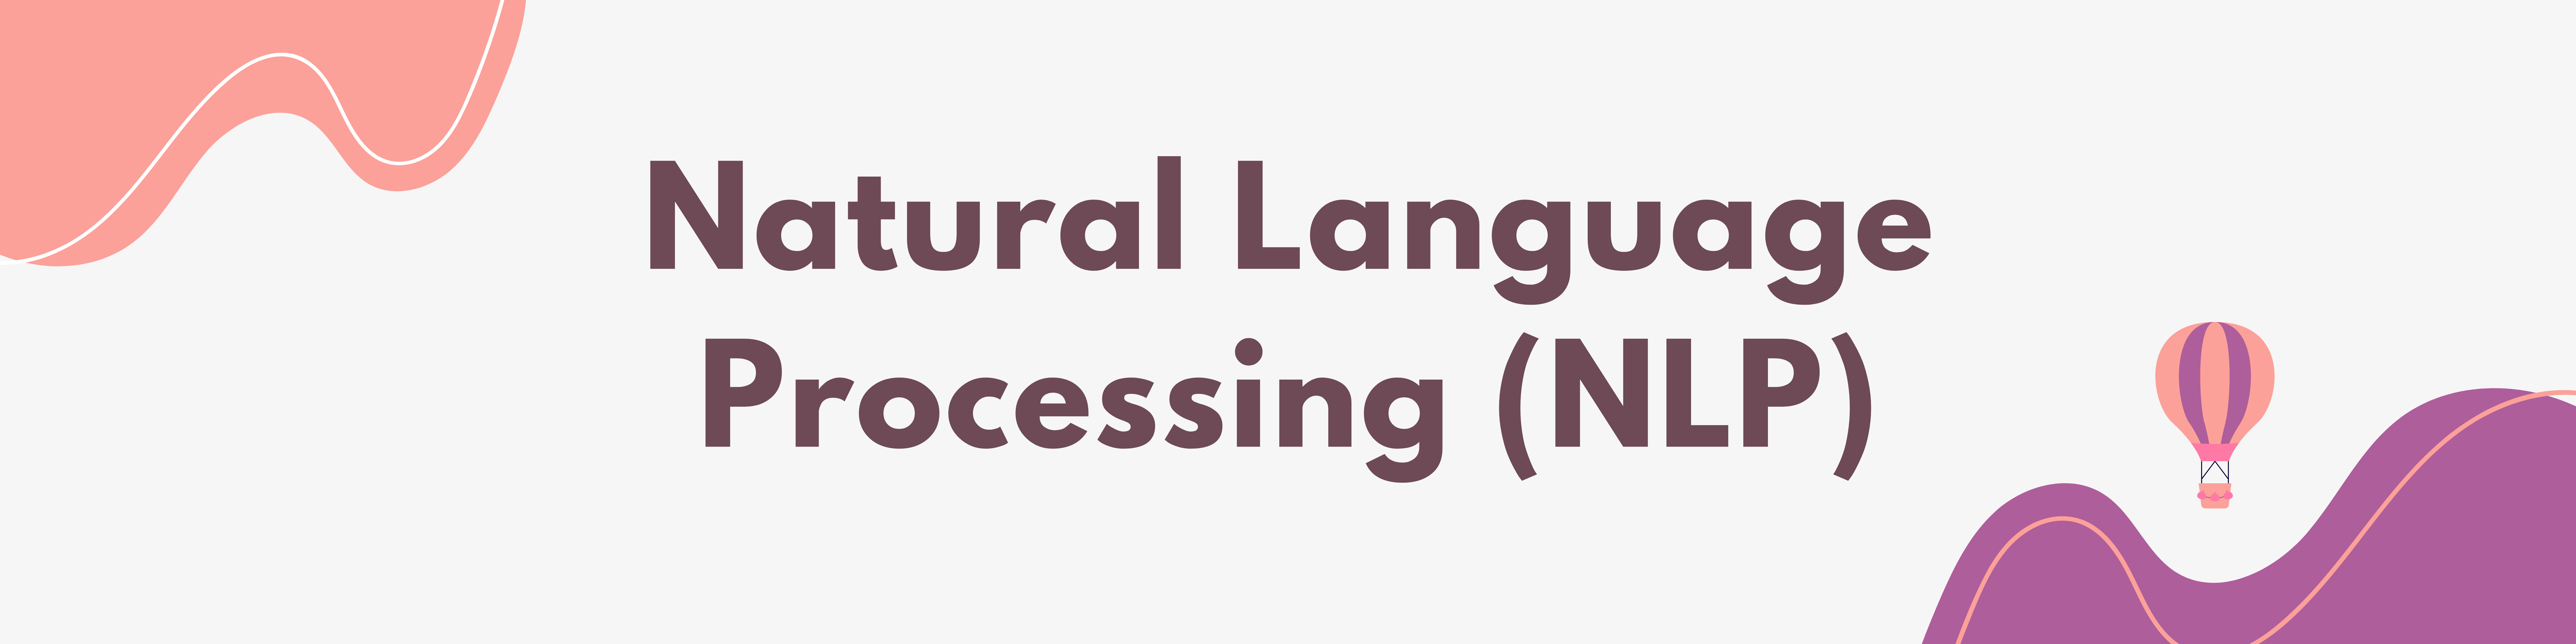

## Instalación de librerías

- Pyspark: https://spark.apache.org/docs/latest/api/python/
- Visualización de temáticas con pyLDAvis: https://pypi.org/project/pyLDAvis/

In [1]:
!pip install pyspark
!pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=d6c3f61666c8d8cc40f5f78c6b1b63f6efc423da46991b84382267b4bc54e849
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 56.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 80.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1

**Importar librerías**

Importamos librerías para el preprocesamiento de texto, LDA y visualización.

In [25]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, lower, size, explode, split, expr
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, NGram
from pyspark.ml.clustering import LDA
from collections import Counter
import numpy as np

import pyLDAvis
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Lectura de base

 **Crear sesión de Spark**

In [2]:
spark = SparkSession.builder\
        .appName("Colab")\
        .getOrCreate()

**Leer información de Reddit**

In [3]:
# La base no tiene encabezado
df = spark.read.option("header",False).csv("/content/part-00000-8e80ca3e-36e6-440a-90c0-34c1c1d67f02-c000.csv")

df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)



Definir nombre de columnas:

In [4]:
df = df.withColumnRenamed("_c0","title").withColumnRenamed("_c1","author")

df.printSchema()

root
 |-- title: string (nullable = true)
 |-- author: string (nullable = true)
 |-- _c2: string (nullable = true)



Eliminar duplicados:

In [5]:
df = df.select(['title','author']).dropDuplicates()

df.count()
# Tamaño de la base: 100 registros

100

## Preprocesamiento de texto

Normalizar:

- Pasar texto en minúsculas
- Símbolos y caracteres especiales 

In [6]:
df_clean = df.select('title', (lower(regexp_replace('title', "[^a-zA-Z\w\s+]", "")).alias('text')))

df_clean.show()

+--------------------+--------------------+
|               title|                text|
+--------------------+--------------------+
|Hi! I created a l...|hi i created a li...|
|Odigos v0.1.5 - M...|odigos v015  mana...|
|Writing my own Ch...|writing my own ch...|
|Cross device pers...|cross device pers...|
|Building a Robust...|building a robust...|
|New to Python and...|new to python and...|
|I just published ...|i just published ...|
|10 Python Itertoo...|10 python itertoo...|
|Python GIL vs. no...|python gil vs nog...|
|Using Taichi to a...|using taichi to a...|
|SteamGiftBot is a...|steamgiftbot is a...|
|Consolidate codes...|consolidate codes...|
|Blog post: Writin...|blog post writing...|
|I am starting my ...|i am starting my ...|
|Python code compr...|python code compr...|
|AI Just KILLED th...|ai just killed th...|
|Compiling a Pytho...|compiling a pytho...|
|You pip install p...|you pip install p...|
|lablup/rraft-py: ...|labluprraftpy uno...|
|Project to train ...|project to

Eliminar registros nulos:

In [7]:
df_clean = df_clean.filter(df_clean.text.isNotNull())
df_clean.na.drop(subset=["text"])
df_clean = df_clean.filter(df_clean.text != "")

df_clean.show()

+--------------------+--------------------+
|               title|                text|
+--------------------+--------------------+
|Hi! I created a l...|hi i created a li...|
|Odigos v0.1.5 - M...|odigos v015  mana...|
|Writing my own Ch...|writing my own ch...|
|Cross device pers...|cross device pers...|
|Building a Robust...|building a robust...|
|New to Python and...|new to python and...|
|I just published ...|i just published ...|
|10 Python Itertoo...|10 python itertoo...|
|Python GIL vs. no...|python gil vs nog...|
|Using Taichi to a...|using taichi to a...|
|SteamGiftBot is a...|steamgiftbot is a...|
|Consolidate codes...|consolidate codes...|
|Blog post: Writin...|blog post writing...|
|I am starting my ...|i am starting my ...|
|Python code compr...|python code compr...|
|AI Just KILLED th...|ai just killed th...|
|Compiling a Pytho...|compiling a pytho...|
|You pip install p...|you pip install p...|
|lablup/rraft-py: ...|labluprraftpy uno...|
|Project to train ...|project to

Tokenizar:

In [26]:
tokenizer = Tokenizer(inputCol='text', outputCol='words_token')
df_words_token = tokenizer.transform(df_clean).select(expr("filter(words_token, x -> x != '') as words_token"))

df_words_token.show()

+--------------------+
|         words_token|
+--------------------+
|[hi, i, created, ...|
|[odigos, v015, ma...|
|[writing, my, own...|
|[cross, device, p...|
|[building, a, rob...|
|[new, to, python,...|
|[i, just, publish...|
|[10, python, iter...|
|[python, gil, vs,...|
|[using, taichi, t...|
|[steamgiftbot, is...|
|[consolidate, cod...|
|[blog, post, writ...|
|[i, am, starting,...|
|[python, code, co...|
|[ai, just, killed...|
|[compiling, a, py...|
|[you, pip, instal...|
|[labluprraftpy, u...|
|[project, to, tra...|
+--------------------+
only showing top 20 rows



Remover stopwords:

In [27]:
remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
df_words_no_stopw = remover.transform(df_words_token).select('words_clean')

df_words_no_stopw.show()

+--------------------+
|         words_clean|
+--------------------+
|[hi, created, lib...|
|[odigos, v015, ma...|
|[writing, chatgpt...|
|[cross, device, p...|
|[building, robust...|
|[new, python, oop...|
|[published, explo...|
|[10, python, iter...|
|[python, gil, vs,...|
|[using, taichi, a...|
|[steamgiftbot, ap...|
|[consolidate, cod...|
|[blog, post, writ...|
|[starting, journe...|
|[python, code, co...|
|[ai, killed, dev,...|
|[compiling, pytho...|
|[pip, install, py...|
|[labluprraftpy, u...|
|[project, train, ...|
+--------------------+
only showing top 20 rows



## Implementación de Latent Dirichlet Allocation (LDA) 

Vectorizar las palabras:

In [28]:
Vector = CountVectorizer(inputCol="words_clean", outputCol="features")
result_vector = Vector.fit(df_words_no_stopw)
result = result_vector.transform(df_words_no_stopw)

result.show()

+--------------------+--------------------+
|         words_clean|            features|
+--------------------+--------------------+
|[hi, created, lib...|(509,[0,4,5,32,67...|
|[odigos, v015, ma...|(509,[1,95,180,20...|
|[writing, chatgpt...|(509,[3,7,18,204]...|
|[cross, device, p...|(509,[71,121,253,...|
|[building, robust...|(509,[0,8,16,294,...|
|[new, python, oop...|(509,[0,2,4,158,2...|
|[published, explo...|(509,[21,23,30,44...|
|[10, python, iter...|(509,[0,3,26,151,...|
|[python, gil, vs,...|(509,[0,29,72,80,...|
|[using, taichi, a...|(509,[0,1,3,37,18...|
|[steamgiftbot, ap...|(509,[0,27,142,26...|
|[consolidate, cod...|(509,[0,6,13,68,8...|
|[blog, post, writ...|(509,[0,15,18,34,...|
|[starting, journe...|(509,[0,19,31,34,...|
|[python, code, co...|(509,[0,3,38,94],...|
|[ai, killed, dev,...|(509,[22,169,374,...|
|[compiling, pytho...|(509,[0,35,88,143...|
|[pip, install, py...|(509,[10,41,64,12...|
|[labluprraftpy, u...|(509,[0,195,361,4...|
|[project, train, ...|(509,[0,20

LDA:

In [32]:
num_topics = 4 # Número de temáticas
max_iterations = 10 # Cantidad de iteraciones 

# LDA
lda = LDA(k=num_topics, maxIter=max_iterations, seed= 3, featuresCol='features') 
lda_model = lda.fit(result)

## Temáticas

Obtener temáticas:

In [33]:
wordNumbers = 40 # Cantidad de palabras por temática
topics = lda_model.describeTopics(maxTermsPerTopic = wordNumbers).select('termIndices').collect()

for topic in topics:
  words = [result_vector.vocabulary[i] for i in topic[0]]
  print(words)
    
document_topics = lda_model.transform(result)
document_topics.show()

['python', 'exploring', 'data', 'script', 'cleaning', 'using', 'code', 'linkedin', 'dexplorer', 'post', 'ai', 'share', 'killed', 'dev', 'terminal', 'image', 'warp', 'automation', 'hindi', 'learn', 'published', 'update', 'made', 'unleashing', 'course', 'power', 'survey', 'chatgpt', 'coding', 'decorators', 'api', 'ive', 'algorithm', 'better', 'b', 'automate', 'rust', 'itertools', 'roblox', 'without']
['install', 'pip', 'protobuf', 'serial', 'looking', 'take', 'data', 'exactly', 'whole', 'process', 'dictionary', 'download', 'import', 'library', 'give', 'compiling', 'schema', 'pyserial', 'distributed', 'numpy', 'plotting', 'gnuplot', 'observability', 'files', 'pythonpygame', 'gnuplotlib', 'collaborators', 'readmemd', 'autogenerate', 'help', 'workflow', 'readmeai', 'code', 'assistant', 'make', 'new', 'computing', 'min', 'quizlet', 'welcome']
['health', 'uploads', 'created', 'thread', 'provides', 'hi', 'suggestions', 'google', 'threads', 'support', 'local', 'simplifies', 'hope', 'superloops'

### WordCloud por temática

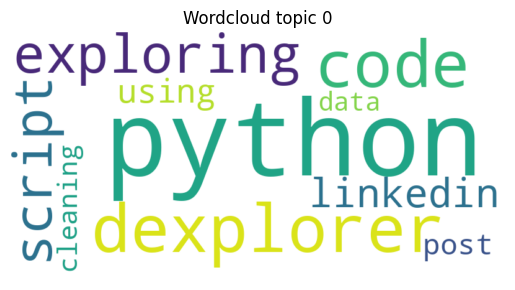

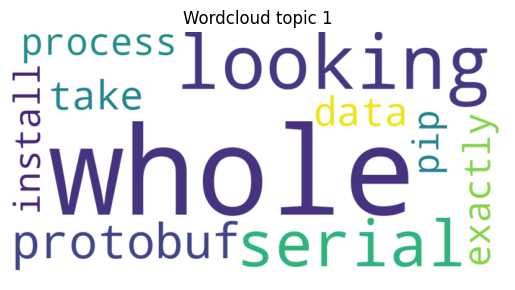

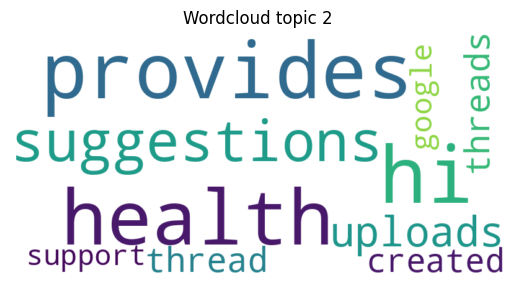

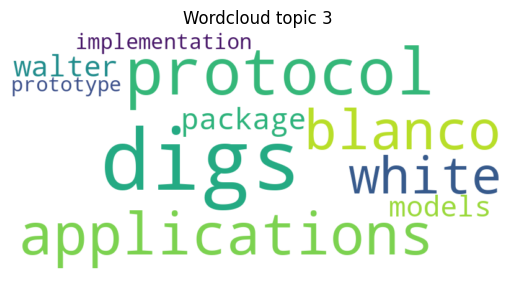

In [34]:
for i in range(num_topics):
    topic_words = [result_vector.vocabulary[idx] for idx in lda_model.describeTopics().select('termIndices').collect()[i][0]]
    word_freqs = dict(zip(topic_words, lda_model.topicsMatrix().toArray()[:, i]))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freqs)
    plt.figure()
    plt.title(f'Wordcloud topic {i}')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

### N-gramas

In [35]:
n = 2  # Número de elementos por n-grama (en este caso, bigramas)
input_col = "words_clean"  # Nombre de la columna que contiene el texto
output_col = "ngramas"  # Nombre de la columna que contendrá los bigramas

# Crea un objeto NGram con los parámetros especificados
ngram_transformer = NGram(n=n, inputCol=input_col, outputCol=output_col)

# Aplica la transformación a los datos de entrada y guarda el resultado en un nuevo DataFrame
dataframe_con_bigramas = ngram_transformer.transform(result)

In [36]:
dataframe_con_bigramas.show()

+--------------------+--------------------+--------------------+
|         words_clean|            features|             ngramas|
+--------------------+--------------------+--------------------+
|[hi, created, lib...|(509,[0,4,5,32,67...|[hi created, crea...|
|[odigos, v015, ma...|(509,[1,95,180,20...|[odigos v015, v01...|
|[writing, chatgpt...|(509,[3,7,18,204]...|[writing chatgpt,...|
|[cross, device, p...|(509,[71,121,253,...|[cross device, de...|
|[building, robust...|(509,[0,8,16,294,...|[building robust,...|
|[new, python, oop...|(509,[0,2,4,158,2...|[new python, pyth...|
|[published, explo...|(509,[21,23,30,44...|[published explor...|
|[10, python, iter...|(509,[0,3,26,151,...|[10 python, pytho...|
|[python, gil, vs,...|(509,[0,29,72,80,...|[python gil, gil ...|
|[using, taichi, a...|(509,[0,1,3,37,18...|[using taichi, ta...|
|[steamgiftbot, ap...|(509,[0,27,142,26...|[steamgiftbot app...|
|[consolidate, cod...|(509,[0,6,13,68,8...|[consolidate code...|
|[blog, post, writ...|(50

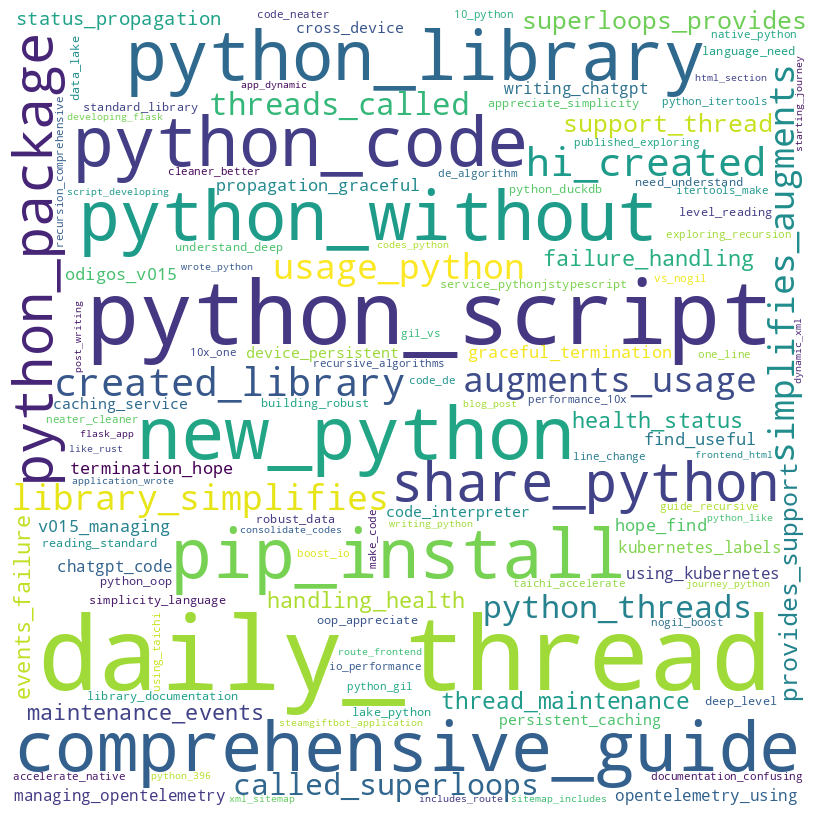

In [37]:
# WordCloud de n-gramas

ngramas_list = [i.ngramas for i in dataframe_con_bigramas.select("ngramas").collect()]

palabras = ["_".join(palabra.split()) for lista in ngramas_list for palabra in lista if len(set(palabra.split())) > 1]

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(" ".join(palabras))
                  
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

In [38]:
Counter(palabras).most_common(10)

[('daily_thread', 4),
 ('python_script', 3),
 ('new_python', 2),
 ('comprehensive_guide', 2),
 ('python_code', 2),
 ('pip_install', 2),
 ('python_library', 2),
 ('python_without', 2),
 ('share_python', 2),
 ('hi_created', 1)]

### pyLDAvis

In [39]:
# Dar formato a los datos para graficar
def format_data_to_pyldavis(df_filtered, count_vectorizer, transformed, lda_model):
    xxx = df_filtered.select((explode(df_filtered.words_clean)).alias("words")).groupby("words").count()
    word_counts = {r['words']:r['count'] for r in xxx.collect()}
    word_counts = [word_counts[w] for w in count_vectorizer.vocabulary]


    data = {'topic_term_dists': np.array(lda_model.topicsMatrix().toArray()).T, 
            'doc_topic_dists': np.array([x.toArray() for x in transformed.select(["topicDistribution"]).toPandas()['topicDistribution']]),
            'doc_lengths': [r[0] for r in df_filtered.select(size(df_filtered.words_clean)).collect()],
            'vocab': count_vectorizer.vocabulary,
            'term_frequency': word_counts}

    return data

# Filtrar solo registros válidos
def filter_bad_docs(data):
    bad = 0
    doc_topic_dists_filtrado = []
    doc_lengths_filtrado = []

    for x,y in zip(data['doc_topic_dists'], data['doc_lengths']):
        if np.sum(x)==0:
            bad+=1
        elif np.sum(x) != 1:
            bad+=1
        elif np.isnan(x).any():
            bad+=1
        else:
            doc_topic_dists_filtrado.append(x)
            doc_lengths_filtrado.append(y)

    data['doc_topic_dists'] = doc_topic_dists_filtrado
    data['doc_lengths'] = doc_lengths_filtrado


data = format_data_to_pyldavis(df_words_no_stopw, result_vector, document_topics, lda_model)
filter_bad_docs(data) 

# Graficar 
py_lda_prepared_data = pyLDAvis.prepare(**data)
pyLDAvis.display(py_lda_prepared_data)

Cerrar sesión de spark:

In [40]:
spark.stop()